In [1]:
import pandas as pd
import sqlite3
import numpy as np
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

# Вспомогательные функции

## Вывод фиксированного колва знаков после запятой

In [2]:
def toFixed(numObj, digits=0):
    return(f"{numObj:.{digits}}")

# Скачаем данные из БД

## Подключимся к БД

In [3]:
conn = sqlite3.connect('Заказы покупателей БД.db')  # Подключимся к БД
cur = conn.cursor()  # Получим объект курсор

## Текст запроса к БД

In [4]:
q = 'select * from Zakaz'

## Получим данные

In [5]:
data = pd.read_sql(q, conn)

# Преобразование data

## Обработка имеющихся данных

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166875 entries, 0 to 166874
Data columns (total 14 columns):
 #   Column                                   Non-Null Count   Dtype 
---  ------                                   --------------   ----- 
 0   ЗаказКлиентаСсылка                       166875 non-null  object
 1   ЗаказКлиентаДата                         166875 non-null  object
 2   ЗаказКлиентаПартнерКод                   166875 non-null  object
 3   ЗаказКлиентаПартнер                      166875 non-null  object
 4   ЗаказКлиентаПартнерБизнесРегион          166875 non-null  object
 5   ЗаказКлиентаПартнерОсновнойМенеджер      166875 non-null  object
 6   ЗаказКлиентаСуммаДокумента               166875 non-null  object
 7   ЗаказКлиентаСтатус                       166875 non-null  object
 8   ЗаказКлиентаНоменклатураКод              166875 non-null  object
 9   ЗаказКлиентаНоменклатура                 166875 non-null  object
 10  ЗаказКлиентаНоменклатураВидНоменклатуры  166

### Преобразуем to_datetime

In [7]:
data['ЗаказКлиентаДата'] = pd.to_datetime(data['ЗаказКлиентаДата'], yearfirst=True, exact=True, format='%Y-%m-%d')
data.sort_values(by=['ЗаказКлиентаДата'], inplace=True, ascending=False)

### Преобразуем to_numeric

In [8]:
data['ЗаказКлиентаСуммаДокумента'] = pd.to_numeric(data['ЗаказКлиентаСуммаДокумента'])
data['ЗаказКлиентаКоличество'] = pd.to_numeric(data['ЗаказКлиентаКоличество'])

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166875 entries, 160660 to 163558
Data columns (total 14 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   ЗаказКлиентаСсылка                       166875 non-null  object        
 1   ЗаказКлиентаДата                         166875 non-null  datetime64[ns]
 2   ЗаказКлиентаПартнерКод                   166875 non-null  object        
 3   ЗаказКлиентаПартнер                      166875 non-null  object        
 4   ЗаказКлиентаПартнерБизнесРегион          166875 non-null  object        
 5   ЗаказКлиентаПартнерОсновнойМенеджер      166875 non-null  object        
 6   ЗаказКлиентаСуммаДокумента               166875 non-null  float64       
 7   ЗаказКлиентаСтатус                       166875 non-null  object        
 8   ЗаказКлиентаНоменклатураКод              166875 non-null  object        
 9   ЗаказКлиентаНоменклат

### Удалим заказы в статусах на "На согласовании" и "К выполнению / В резерве"

In [10]:
data.drop(index = data.loc[data['ЗаказКлиентаСтатус'] == 'На согласовании'].index, axis = 0, inplace=True)
data.drop(index = data.loc[data['ЗаказКлиентаСтатус'] == 'К выполнению / В резерве'].index, axis = 0, inplace=True)

In [11]:
data.reset_index(inplace=True) #сбросим имеющиеся индексы и воссоздадим по порядку заново
del data['index']

## Добавим новые метрики

### Добавим метрику растояний

In [12]:
otNovosibirska = {'Адыгея Респ':4000, 'Акмолинская область':1200, 'Актюбинская область':2400, 'Алматинская область':1800, 'Алтай Респ':450,
     'Алтайский край':230, 'Амурская обл':4300, 'Архангельская обл':3300, 'Астраханская обл':3600, 'Астрахань':3600, 'Атырауская область':2800,
     'Барнаул':230, 'Башкортостан Респ':2000, 'Белгород':3600, 'Белгородская обл':3600, 'Бишкек':2000, 'Благовещенск':4300,
     'Брянская обл':3700, 'Бурятия Респ':2300, 'Владимирская обл':3200, 'Волгоградская обл':3200, 'Вологодская обл':3000, 'Воронежская обл':3300,
     'Восточно-Казахстанская область':740, 'Дальневосточный ФО':None, 'Еврейская Аобл':4700, 'Екатеринбург':6400, 'Иркутская обл':1800,
     'Казань':2500, 'Казахстан':None, 'Калининградская обл':None, 'Калужская обл':3600, 'Камчатская обл':None, 'Карагандинская область':1000,
     'Кемерово':260, 'Кемеровская обл':260, 'Кировская обл':2500, 'Коми Респ':3200, 'Краснодар':4000, 'Краснодарский край':4000,
     'Красноярск':790, 'Красноярский край':790, 'Курганская обл':1200, 'Кызылординская область':2000, 'Ленинградская обл':4000,
     'Липецкая обл':3300, 'МОНГОЛИЯ':2700, 'Магаданская обл':6700, 'Мангистауская область':3400, 'Марий Эл Респ':2700, 'Мордовия Респ':2900,
     'Москва':3400, 'Московская обл':3400, 'Мурманск':4600, 'Мурманская обл':4600, 'Ненецкий АО':3900, 'Нижегородская обл':3000,
     'Новокузнецк':370, 'Новосибирск':1, 'Новосибирская обл':1, 'Омская обл':650, 'Оренбург':2300, 'Оренбургская обл':2300,
     'Орловская обл':3500, 'Павлодарская обл':670, 'Пензенская обл':2900, 'Пермская обл':2000, 'Пермь':2000, 'Петрозаводск':3900,
     'Приволжский ФО':None, 'Приморский край':3500, 'Республика Крым':4400, 'Ростов-на-Дону':3700, 'Ростовская обл':3700,
     'Рязанская обл':3300, 'Рязань':3300, 'Самарская обл':2400, 'Санкт-Петербург':3900, 'Саратовская обл':2800, 'Саха /Якутия/ Респ':5000,
     'Сахалинская обл':6100, 'Свердловская обл':1700, 'Северо-Западный ФО':None, 'Северо-Казахстанская область':930, 'Сибирский ФО':None,
     'Смоленская обл':3700, 'Ставрополь':3800, 'Ставропольский край':3800, 'Таймырский АО':2700, 'Тамбовская обл':3100, 'Татарстан Респ':2400,
     'Теркестанская обл':None, 'Томская обл':900, 'Тульская обл':3500, 'Тыва Респ':1300, 'Тюменская обл':1300, 'Удмуртская Респ':2300,
     'Ульяновская обл':2700, 'Уральский ФО':None, 'Хабаровский край':5000, 'Хакасия Респ':1000, 'Ханты-Мансийский - Югра АО':1800,
     'Химки':3400, 'Центральный ФО':None, 'Челябинск':1600, 'Челябинская обл':1600, 'Читинская обл':2800, 'Чувашская - Чувашия Респ':2700,
     'Чукотский АО':None, 'Южно-Сахалинск':5900, 'Якутск':5000, 'Ямало-Ненецкий АО':2600, 'Ярославская обл':3200}
    
    # добавим данные о растоянии в DF
data['RastoynieOtNSK'] = None
for number, series in tqdm.tqdm(data.iterrows(), ncols = len(data)):
    data.at[number, "RastoynieOtNSK"] = otNovosibirska.get(series['ЗаказКлиентаПартнерБизнесРегион'])

162519it [00:13, 12347.09it/s]


### Метрика свойств

In [13]:
# добавим новый столбец
data['Sv_1'] = 'Не определено'

#### Процедура замены

In [14]:
def changing(data, svoystvo):
    for elem in list_nomenklatura:
        IndexIzmenit = data.loc[data['ЗаказКлиентаНоменклатура'] == elem].index
        data.loc[IndexIzmenit, 'Sv_1'] = svoystvo

#### Шкаф 310

In [15]:
list_nomenklatura = ['310 ШП-К1 (Н) ЗБ - Евро', '310 ШП-К1 (Н) ОБ - Евро', '310 ШП-К1 (Н) ОБ -Замок',
                     '310 ШП-К1 (Н)ЗК - Евро', '310 ШП-К1 (Н)ЗК -Замок', '310 ШП-К1 (Н)ОК - Евро',
                     '310 ШП-К1 (Н)ОК -Замок', '310 ШП-К1 (Н) ЗБ -Замок', '310Э ШП-К1 (Н)ЗК -Замок',
                     '310Э ШП-К1 (Н)ОК -Замок', '310Э ШП-К1 (Н) ОБ -Замок', '310Э ШП-К1 (Н) ЗБ -Замок',
                     '310Э ШП-К1 (Н) ОБ -Евро', '310Э ШП-К1 (Н)ЗК -Евро', '310Э ШП-К1 (Н)ОК -Евро',
                     '310 ШП-К1 НЕ СТАНДАРТ', '310Э ШП-К1 (Н) ЗБ - Евро'
                     ]

In [16]:
changing(data, '310')

#### Шкаф 315

In [17]:
list_nomenklatura = ['315 ШП-К1-О1 (Н) ЗБ -Замок', '315 ШП-К1-О1 (Н) ОБ - Евро', '315 ШП-К1-О1 (Н) ОБ -Замок',
                     '315 ШП-К1-О1 (Н)ЗК - Евро', '315 ШП-К1-О1 (Н)ЗК -Замок', '315 ШП-К1-О1 (Н)ОК - Евро',
                     '315 ШП-К1-О1 (Н)ОК -Замок', '315 ШП-К1-О1 НЕ СТАНДАРТ', '315Э ШП-К1-О1 (Н) ЗБ - Евро',
                     '315Э ШП-К1-О1 (Н) ЗБ -Замок', '315Э ШП-К1-О1 (Н) ОБ - Евро', '315Э ШП-К1-О1 (Н) ОБ -Замок',
                     '315Э ШП-К1-О1 (Н)ЗК - Евро', '315Э ШП-К1-О1 (Н)ЗК -Замок', '315Э ШП-К1-О1 (Н)ОК - Евро',
                     '315Э ШП-К1-О1 (Н)ОК -Замок', '315 ШП-К1-О1 (Н) ЗБ - Евро'
                     ]

In [18]:
changing(data, '315')

#### Шкаф 320

In [19]:
list_nomenklatura = ['320 ШП-К1-О2 (Н) ЗБ - Евро', '320 ШП-К1-О2 (Н) ЗБ -Замок', '320 ШП-К1-О2 (Н) ОБ - Евро',
                     '320 ШП-К1-О2 (Н) ОБ -Замок', '320 ШП-К1-О2 (Н)ЗК - Евро', '320 ШП-К1-О2 (Н)ЗК -Замок',
                     '320 ШП-К1-О2 (Н)ОК - Евро', '320 ШП-К1-О2 (Н)ОК -Замок', '320 ШП-К1-О2 НЕ СТАНДАРТ',
                     '320Э ШП-К1-О2 (Н) ЗБ - Евро', '320Э ШП-К1-О2 (Н) ЗБ -Замок', '320Э ШП-К1-О2 (Н) ОБ - Евро',
                     '320Э ШП-К1-О2 (Н) ОБ -Замок', '320Э ШП-К1-О2 (Н)ЗК - Евро', '320Э ШП-К1-О2 (Н)ЗК -Замок',
                     '320Э ШП-К1-О2 (Н)ОК - Евро', '320Э ШП-К1-О2 (Н)ОК -Замок'
                     ]

In [20]:
changing(data, '320')

#### Шкаф 321

In [21]:
list_nomenklatura = ['3201 ШП-К2 (Н) ЗБ - Евро', '3201 ШП-К2 (Н) ЗБ -Замок', '3201 ШП-К2 (Н) ОБ - Евро',
                     '3201 ШП-К2 (Н) ОБ -Замок', '3201 ШП-К2 (Н)ЗК - Евро', '3201 ШП-К2 (Н)ЗК -Замок',
                     '3201 ШП-К2 (Н)ОК - Евро', '3201 ШП-К2 (Н)ОК -Замок', '3201 ШП-К2 НЕ СТАНДАРТ',
                     '3201Э ШП-К2 (Н) ЗБ - Евро', '3201Э ШП-К2 (Н) ЗБ -Замок', '3201Э ШП-К2 (Н) ОБ - Евро',
                     '3201Э ШП-К2 (Н) ОБ -Замок', '3201Э ШП-К2 (Н)ЗК - Евро', '3201Э ШП-К2 (Н)ЗК -Замок',
                     '3201Э ШП-К2 (Н)ОК - Евро', '3201Э ШП-К2 (Н)ОК -Замок'
                     ]

In [22]:
changing(data, '321')

#### Классик + Сибтекс 50

In [23]:
list_nomenklatura = [
    'Классик 50 РПК(В)-Н/В-50-1,0-М-УХЛ1 "Сибтекс" в сборе с ГР-50А',
    'Классик 50 РПК(В)-Н/В-50-1,0-М-УХЛ1 "Сибтекс" в сборе с ГР-50А, РС-50.01А',
    'Классик 50 РПК(В)-Н/В-50-1,0-М-УХЛ1 "Сибтекс" в сборе с ГР-50АП',
    'Классик 50 РПК(В)-Н/В-50-1,0-М-УХЛ1 "Сибтекс" в сборе с ГР-50АП, РС-50.01А',
    'Классик 50 РПК(В)-Н/В-50-1,0-М-УХЛ1 "Сибтекс" в сборе с ГР-50АП, РС-50.01П',
    'Классик 50 РПК(В)-Н/В-50-1,0-М-УХЛ1 "Сибтекс" в сборе с ГР-50П',
    'Классик 50 РПК(В)-Н/В-50-1,0-М-УХЛ1 "Сибтекс" в сборе с ГР-50П, РС-50.01А',
    'Классик 50 РПК(В)-Н/В-50-1,0-М-УХЛ1 "Сибтекс" в сборе с ГР-50П, РС-50.01П',
    'Сибтекс РПК-В/Н-50-1,0-У1',
    'Сибтекс РПК-В/Н-50-1,0-У1 с ГР-50А',
    'Сибтекс РПК-В/Н-50-1,0-У1 с ГР-50А, РС-50',
    'Сибтекс РПК-В/Н-50-1,0-У1 с ГР-50А, РС-50.01А',
    'Сибтекс РПК-В/Н-50-1,0-У1 с ГР-50А, РС-50.01П',
    'Сибтекс РПК-В/Н-50-1,0-У1 с ГР-50АП',
    'Сибтекс РПК-В/Н-50-1,0-У1 с ГР-50АП, РС-50.01А',
    'Сибтекс РПК-В/Н-50-1,0-У1 с ГР-50АП, РС-50.01П',
    'Сибтекс РПК-В/Н-50-1,0-У1 с ГР-50П',
    'Сибтекс РПК-В/Н-50-1,0-У1 с ГР-50П, РС-50.01П',
    'Классик 50 РПК(В)-Н/В-50-1,0-М-УХЛ1 "Сибтекс"'
]

In [24]:
changing(data, 'Рук')

#### Классик + Сибтекс 65

In [25]:
list_nomenklatura = [
    'Классик 65 РПК(В)-Н/В-65-1,0-М-УХЛ1 "Сибтекс"',
    'Классик 65 РПК(В)-Н/В-65-1,0-М-УХЛ1"Сибтекс" в сборе с ГР-65А',
    'Классик 65 РПК(В)-Н/В-65-1,0-М-УХЛ1"Сибтекс" в сборе с ГР-65А, РС-65.01А',
    'Классик 65 РПК(В)-Н/В-65-1,0-М-УХЛ1"Сибтекс" в сборе с ГР-65А, РС-65.01П',
    'Классик 65 РПК(В)-Н/В-65-1,0-М-УХЛ1"Сибтекс" в сборе с ГР-65АП',
    'Классик 65 РПК(В)-Н/В-65-1,0-М-УХЛ1"Сибтекс" в сборе с ГР-65АП, РС-65.01А',
    'Классик 65 РПК(В)-Н/В-65-1,0-М-УХЛ1"Сибтекс" в сборе с ГР-65АП, РС-65.01П',
    'Классик 65 РПК(В)-Н/В-65-1,0-М-УХЛ1"Сибтекс" в сборе с ГР-65П',
    'Классик 65 РПК(В)-Н/В-65-1,0-М-УХЛ1"Сибтекс" в сборе с ГР-65П, РС-65.01П',
    'Рукав пожарный напорный РПК-В/Н-65-1,0-У1 "Сибтекс"',
    'Рукав пожарный напорный РПК-В/Н-65-1,0-У1 "Сибтекс" в сборе с ГР-65А'
]

In [26]:
changing(data, 'Рук')

#### Клапана в ассортименте

In [27]:
list_nomenklatura = [
    'Вентиль чугунный фл. 15кч19п Ду 50 Ру 16',
    'Клапан ДУ-50 прямой латунный 15Б3Р (НЗГА) М-М',
    'Клапан ДУ-50 прямой латунный 15Б3Р М-М',
    'Клапан ДУ-50 прямой латунный 15Б3Р М-Ц',
    'Клапан пожарного крана КПК-50 (чугун, Ц-Ц, угловой, 125 град)',
    'Клапан пожарного крана КПК-Ч-50 (чугун, М-Ц, прямой, 180 град.)',
    'Клапан пожарного крана КПК-Ч-50 (чугун, М-Ц, угловой, 125 град.)',
    'Клапан пожарного крана КПК-Ч-65 (чугун, М-Ц, прямой, 180 град.)',
    'Клапан пожарного крана КПК-Ч-65 (чугун, М-Ц, угловой, 125 град.)',
    'Клапан пожарного крана КПЛ-50 (латунь, М-М, прямой, 180 град.)',
    'Клапан пожарного крана КПЛ-50 (латунь, М-Ц, прямой, 180 град.)',
    'Клапан пожарного крана КПЛ-50 (латунь, М-Ц, угловой, 125 град.)',
    'Клапан пожарного крана КПЛ-50 (латунь, М-Ц, угловой, 90 град.)',
    'Клапан пожарного крана КПЛ-65 (латунь, М-Ц, прямой, 180 град.)',
    'Клапан пожарного крана КПЛ-65 (латунь, М-Ц, угловой, 125 град.)',
    'Клапан пожарного крана КПЛ-65 (латунь, М-Ц, угловой, 90 град.)',
    'Клапан пожарный РПТК 50 (чугун, М-Ц, угловой, 120 град)',
    'Клапан пожарный РПТК 65 (чугун, М-Ц, угловой, 120 град)',
    'Вентиль чугунный  D50 (15кч11р) М-Ц'
]

In [28]:
changing(data, 'Клап')

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162519 entries, 0 to 162518
Data columns (total 16 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   ЗаказКлиентаСсылка                       162519 non-null  object        
 1   ЗаказКлиентаДата                         162519 non-null  datetime64[ns]
 2   ЗаказКлиентаПартнерКод                   162519 non-null  object        
 3   ЗаказКлиентаПартнер                      162519 non-null  object        
 4   ЗаказКлиентаПартнерБизнесРегион          162519 non-null  object        
 5   ЗаказКлиентаПартнерОсновнойМенеджер      162519 non-null  object        
 6   ЗаказКлиентаСуммаДокумента               162519 non-null  float64       
 7   ЗаказКлиентаСтатус                       162519 non-null  object        
 8   ЗаказКлиентаНоменклатураКод              162519 non-null  object        
 9   ЗаказКлиентаНоменклатура  

# Отберем заказы с анализируемыми товарами

In [30]:
data_2 = data.loc[data['Sv_1'] != 'Не определено'].copy()
data_2.reset_index(inplace=True) #сбросим имеющиеся индексы и воссоздадим по порядку заново
del data_2['index']
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20968 entries, 0 to 20967
Data columns (total 16 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   ЗаказКлиентаСсылка                       20968 non-null  object        
 1   ЗаказКлиентаДата                         20968 non-null  datetime64[ns]
 2   ЗаказКлиентаПартнерКод                   20968 non-null  object        
 3   ЗаказКлиентаПартнер                      20968 non-null  object        
 4   ЗаказКлиентаПартнерБизнесРегион          20968 non-null  object        
 5   ЗаказКлиентаПартнерОсновнойМенеджер      20968 non-null  object        
 6   ЗаказКлиентаСуммаДокумента               20968 non-null  float64       
 7   ЗаказКлиентаСтатус                       20968 non-null  object        
 8   ЗаказКлиентаНоменклатураКод              20968 non-null  object        
 9   ЗаказКлиентаНоменклатура               

## Выделим свойства состава табличной части

In [31]:
uniques = data_2['ЗаказКлиентаСсылка'].unique()
len(uniques)

11268

In [32]:
time_list = []
orders = dict()
for elem in tqdm.tqdm(uniques):
    order = data_2.loc[data_2['ЗаказКлиентаСсылка'] == elem]
    properties = '*'.join(sorted(list(order['Sv_1'].unique())))
    
    result = orders.setdefault(properties, [elem])
    if result is not None:
        if elem not in result:
            result.append(elem)
            orders.setdefault(properties, [result])
len(orders)

100%|███████████████████████████████████████████████████████████████████████████| 11268/11268 [00:21<00:00, 512.86it/s]


57

In [33]:
# Удалим данные с единичным ключом
keys = list(orders.keys())
for elem in keys:
    if (len(elem.split('*'))) == 1:
        orders.pop(elem)
print(f'После удаления единичного ключа кол-во свойств: {len(orders)}')

# Удалим данные без "Клапан для ПК" или "рукав ПК"
keys = list(orders.keys())
for elem in keys:
    if ("Клап" and "Рук") not in elem.split('*'):
        orders.pop(elem)
print(f'После удаления не полных ключей кол-во свойств: {len(orders)}\n')

print('Ключи к дальнейшей обработке')
# Итого ключи к дальнейшей обработке
for elem in sorted(orders.keys()):
    print(elem)

После удаления единичного ключа кол-во свойств: 51
После удаления не полных ключей кол-во свойств: 27

Ключи к дальнейшей обработке
310*315*320*321*Рук
310*315*320*Клап*Рук
310*315*320*Рук
310*315*321*Клап*Рук
310*315*Клап*Рук
310*315*Рук
310*320*321*Клап*Рук
310*320*321*Рук
310*320*Клап*Рук
310*320*Рук
310*321*Клап*Рук
310*321*Рук
310*Клап*Рук
310*Рук
315*320*Клап*Рук
315*320*Рук
315*321*Клап*Рук
315*321*Рук
315*Клап*Рук
315*Рук
320*321*Клап*Рук
320*321*Рук
320*Клап*Рук
320*Рук
321*Клап*Рук
321*Рук
Клап*Рук


## Добавим дополнительные свойства

In [34]:
data_2['Sv_2'] = None
data_2['Sv_3'] = None
data_2['Sv_4'] = None
data_2['Sv_5'] = None
data_2['Sv_6'] = None

keys = list(orders.keys())

for elem, series in data_2.iterrows():
    for key in keys:
        list_orders = orders.get(key)
        if series['ЗаказКлиентаСсылка'] in list_orders:
            data_2.at[elem, 'Sv_2'] = (series['Sv_1'] + '*' +
                                             series['ЗаказКлиентаОтменено'])
            data_2.at[elem, 'Sv_3'] = key
            data_2.at[elem, 'Sv_4'] = (key + '*' +
                                             series['ЗаказКлиентаОтменено'])
            data_2.at[elem, 'Sv_5'] = (key + '/' + series['Sv_1'] +
                                             '_' +
                                             series['ЗаказКлиентаОтменено'])
            
for elem, series in data_2.iterrows():
    for key in keys:
        list_orders = orders.get(key)
        if series['ЗаказКлиентаСсылка'] in list_orders:
            part_2 = data_2.loc[data_2['ЗаказКлиентаСсылка'] == series['ЗаказКлиентаСсылка']]
            #part_2 = part_2.loc[part_2['Svoystvo'] != None]
            #print(part_2['Svoystvo_2'].unique())
            #print(data_2['ЗаказКлиентаСсылка'])

            part_2 = sorted(list(part_2['Sv_2'].unique()))
            part_2 = '*'.join(part_2)


            data_2.at[elem, 'Sv_6'] = (series['Sv_4'] + '/' + part_2)

In [35]:
data_2['Sv_6'].unique()

array(['310*315*Рук*Да/310*Нет*315*Да*Рук*Нет',
       '310*315*Рук*Нет/310*Нет*315*Да*Рук*Нет',
       '320*Клап*Рук*Нет/320*Нет*Клап*Нет*Рук*Нет', None,
       '310*Рук*Нет/310*Нет*Рук*Нет', 'Клап*Рук*Нет/Клап*Нет*Рук*Нет',
       'Клап*Рук*Да/Клап*Да*Рук*Да',
       '320*Клап*Рук*Да/320*Да*Клап*Да*Рук*Да',
       '315*Рук*Нет/315*Да*Рук*Нет',
       '310*315*Рук*Да/310*Да*315*Да*Рук*Да', '315*Рук*Да/315*Да*Рук*Нет',
       '310*320*Клап*Рук*Нет/310*Нет*320*Нет*Клап*Нет*Рук*Нет',
       '310*320*Клап*Рук*Да/310*Да*320*Да*Клап*Да*Рук*Да',
       '310*321*Рук*Да/310*Да*321*Да*Рук*Да', '320*Рук*Да/320*Да*Рук*Да',
       '310*Рук*Да/310*Да*Рук*Да',
       '310*Клап*Рук*Нет/310*Нет*Клап*Нет*Рук*Нет',
       '310*Клап*Рук*Да/310*Да*Клап*Да*Рук*Да',
       '321*Рук*Нет/321*Да*321*Нет*Рук*Нет',
       '321*Рук*Да/321*Да*321*Нет*Рук*Нет',
       '315*Клап*Рук*Да/315*Да*Клап*Да*Рук*Да',
       '315*Рук*Нет/315*Да*315*Нет*Рук*Нет',
       '315*Рук*Да/315*Да*315*Нет*Рук*Нет',
       '310*321*Кла

In [36]:
data_2[:1]

,ЗаказКлиентаСсылка,ЗаказКлиентаДата,ЗаказКлиентаПартнерКод,ЗаказКлиентаПартнер,ЗаказКлиентаПартнерБизнесРегион,ЗаказКлиентаПартнерОсновнойМенеджер,ЗаказКлиентаСуммаДокумента,ЗаказКлиентаСтатус,ЗаказКлиентаНоменклатураКод,ЗаказКлиентаНоменклатура,...,ЗаказКлиентаКоличество,ЗаказКлиентаОтменено,ЗаказКлиентаПричинаОтмены,RastoynieOtNSK,Sv_1,Sv_2,Sv_3,Sv_4,Sv_5,Sv_6
0,Заказ клиента ЭЛ00-007424 от 22.05.2020 13:34:14,2020-05-22,00-00000149,Арзамасцева Любовь Петровна,Бурятия Респ,Белоусова Татьяна Юрьевна,7468.0,Закрыт,00000007493,315 ШП-К1-О1 (Н)ЗК -Замок,...,2.0,Да,Да,2300,315,315*Да,310*315*Рук,310*315*Рук*Да,310*315*Рук/315_Да,310*315*Рук*Да/310*Нет*315*Да*Рук*Нет


# Набор с 310

## Отберем данные из 310 набора

In [37]:
# Сначала отберем заказы с набором из 310 корпуса
data_3_1 = data_2.loc[data_2['Sv_3'] == '310*Клап*Рук']
data_3_2 = data_2.loc[data_2['Sv_3'] == '310*Рук']
data_3_3 = data_2.loc[data_2['Sv_3'] == '310*Клап']
data_3_4= data_2.loc[data_2['Sv_3'] == 'Клап*Рук']
data_3 = pd.concat([data_3_1, data_3_2, data_3_3, data_3_4])

## Корреляция по свойствам без признака продажи Svoystvo

In [38]:
data_310 = pd.get_dummies(data_3['Sv_1'])

In [39]:
data_310.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4200 entries, 238 to 20934
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   310     4200 non-null   uint8
 1   Клап    4200 non-null   uint8
 2   Рук     4200 non-null   uint8
dtypes: uint8(3)
memory usage: 45.1 KB


In [40]:
corrmat = data_310.corr(method='pearson')
top_corr_features = corrmat.index
plt.figure(figsize=(8,8))
# Конфиденциальная информация
# g=sns.heatmap(data_310[top_corr_features].corr(),annot=True,cmap="RdYlGn")

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

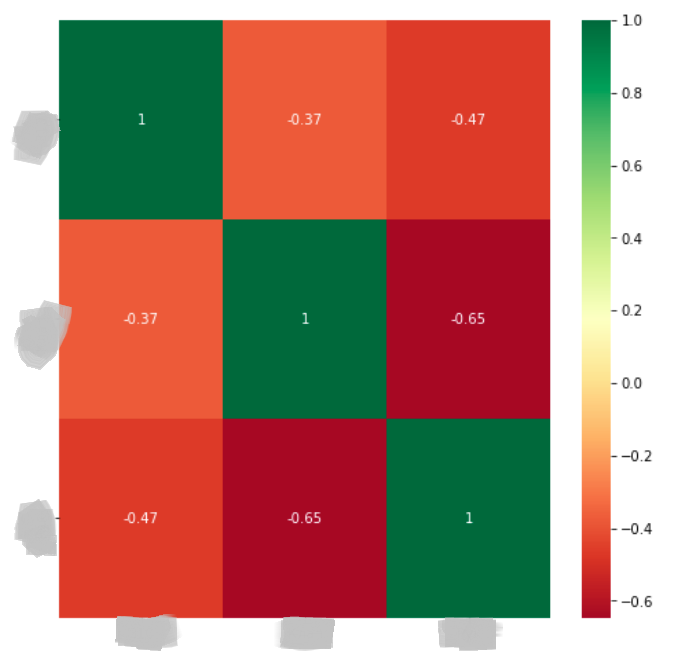

In [41]:
Image("1.png") 

## Корреляция по свойствам c признака продажи Svoystvo_2

In [42]:
data_310 = pd.get_dummies(data_3['Sv_2'])

In [43]:
data_310.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4200 entries, 238 to 20934
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   310*Да    4200 non-null   uint8
 1   310*Нет   4200 non-null   uint8
 2   Клап*Да   4200 non-null   uint8
 3   Клап*Нет  4200 non-null   uint8
 4   Рук*Да    4200 non-null   uint8
 5   Рук*Нет   4200 non-null   uint8
dtypes: uint8(6)
memory usage: 57.4 KB


In [44]:
corrmat = data_310.corr(method='pearson')
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
# Конфиденциальная информация
# g=sns.heatmap(data_310[top_corr_features].corr(),annot=True,cmap="RdYlGn")

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

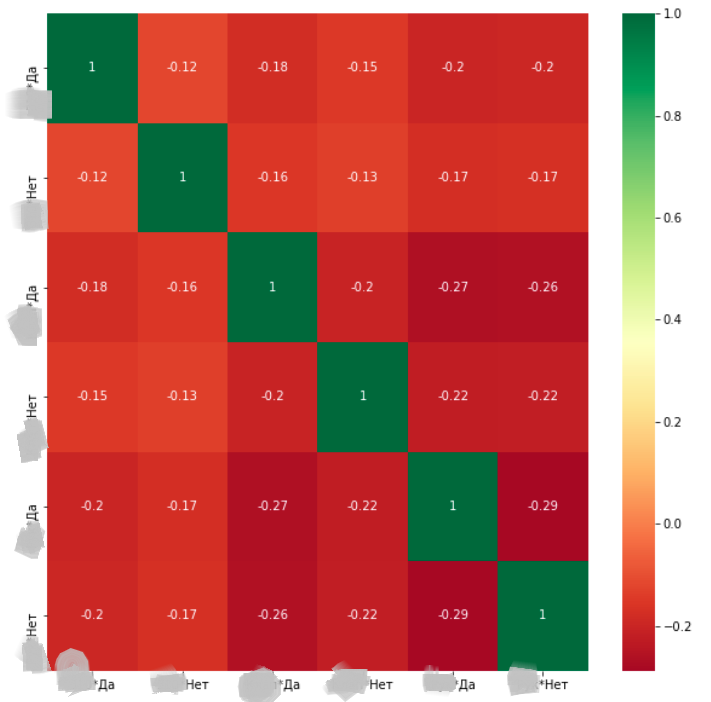

In [45]:
Image("2.png") 

## Корреляция по свойствам без признака продажи Svoystvo_3

In [46]:
data_3['Sv_3'].unique()

array(['310*Клап*Рук', '310*Рук', 'Клап*Рук'], dtype=object)

In [47]:
data_310 = pd.get_dummies(data_3['Sv_3'])
corrmat = data_310.corr(method='pearson')
top_corr_features = corrmat.index
plt.figure(figsize=(8,8))
# Конфиденциальная информация
# g=sns.heatmap(data_310[top_corr_features].corr(),annot=True,cmap="RdYlGn")

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

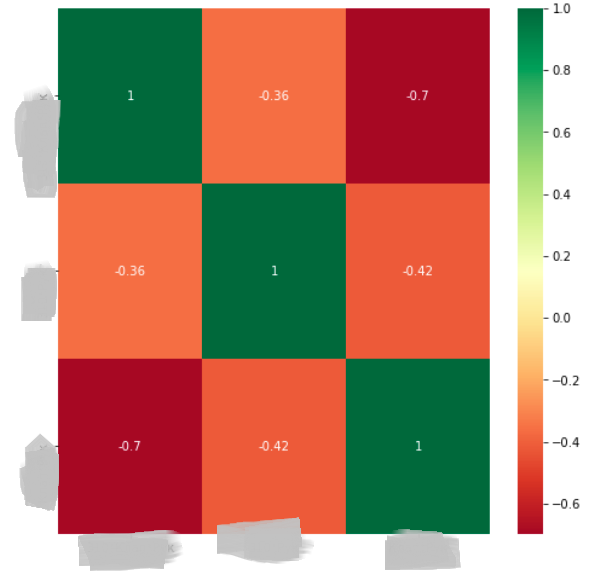

In [48]:
Image("3.png") 

## Корреляция по составу свойств с признаком продажи Svoystvo_4

In [49]:
data_3['Sv_4'].unique()

array(['310*Клап*Рук*Нет', '310*Клап*Рук*Да', '310*Рук*Нет', '310*Рук*Да',
       'Клап*Рук*Нет', 'Клап*Рук*Да'], dtype=object)

In [50]:
data_310 = pd.get_dummies(data_3['Sv_4'])
corrmat = data_310.corr(method='pearson')
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
# Конфиденциальная информация
# g=sns.heatmap(data_310[top_corr_features].corr(),annot=True,cmap="RdYlGn")

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

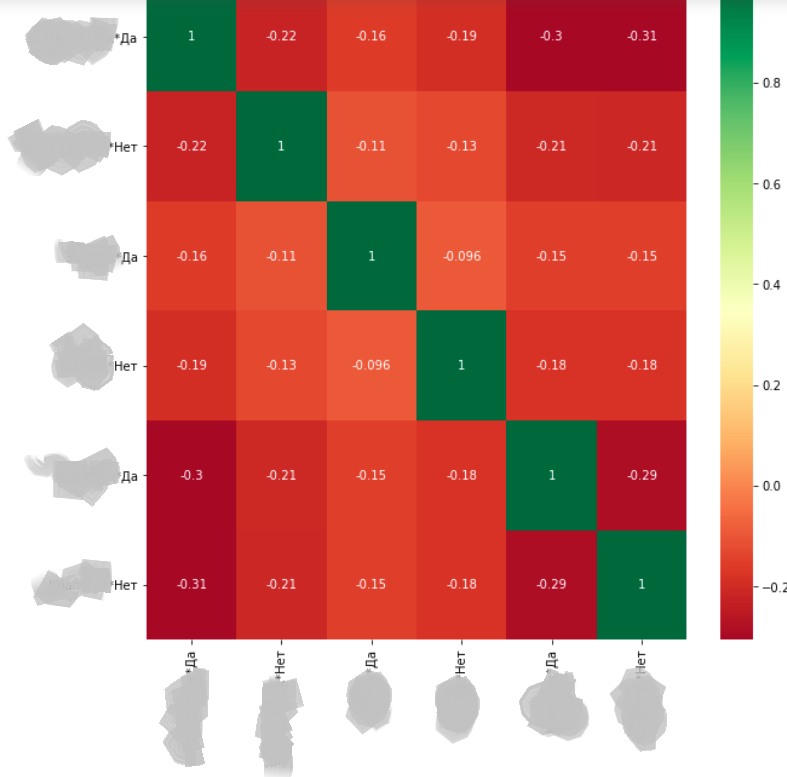

In [51]:
Image("4.png") 

In [52]:
data_3['Sv_5'].unique()

array(['310*Клап*Рук/310_Нет', '310*Клап*Рук/Клап_Да',
       '310*Клап*Рук/Рук_Нет', '310*Клап*Рук/Клап_Нет',
       '310*Клап*Рук/Рук_Да', '310*Клап*Рук/310_Да', '310*Рук/Рук_Нет',
       '310*Рук/310_Нет', '310*Рук/Рук_Да', '310*Рук/310_Да',
       'Клап*Рук/Клап_Нет', 'Клап*Рук/Рук_Нет', 'Клап*Рук/Рук_Да',
       'Клап*Рук/Клап_Да'], dtype=object)

In [53]:
data_310 = pd.get_dummies(data_3[['Sv_5', 'Sv_4']])
corrmat = data_310.corr(method='pearson')
top_corr_features = corrmat.index
plt.figure(figsize=(15,15))
# Конфиденциальная информация
# g=sns.heatmap(data_310[top_corr_features].corr(),annot=True,cmap="RdYlGn")

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

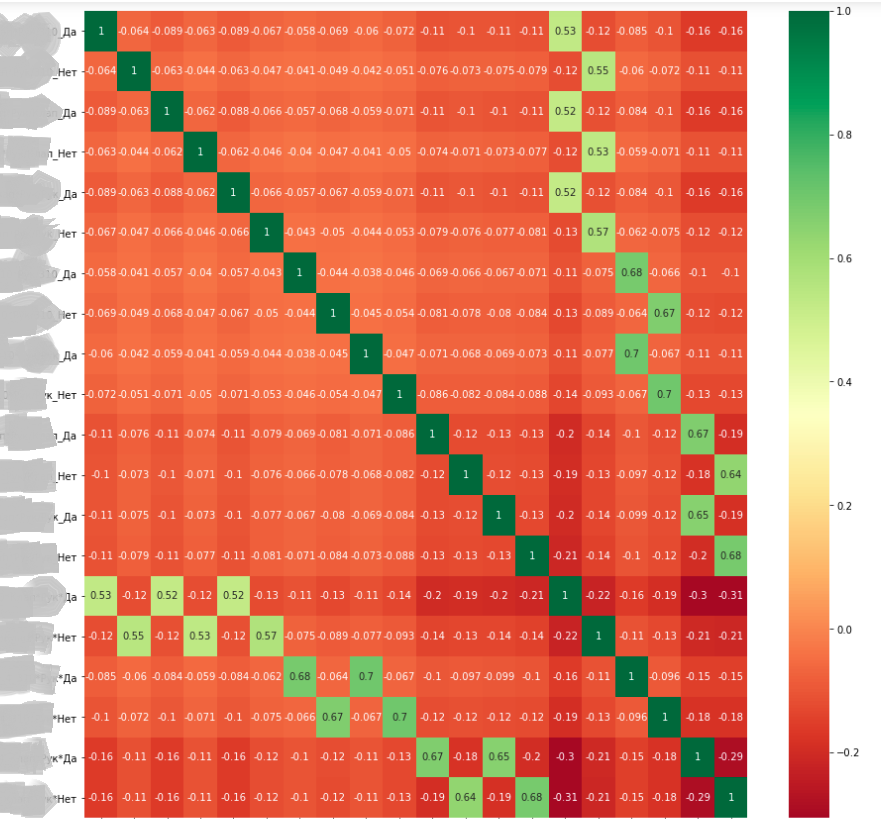

In [54]:
Image("5.png") 

In [55]:
data_Y = data_2.loc[data_2['Sv_4'] == '310*Клап*Рук*Да']
data_N = data_2.loc[data_2['Sv_4'] == '310*Клап*Рук*Нет']
data_YN = pd.concat([data_Y,data_N])

In [56]:
data_310 = pd.get_dummies(data_YN[['Sv_6', 'Sv_4']])
corrmat = data_310.corr(method='pearson')
top_corr_features = corrmat.index
plt.figure(figsize=(15,15))
# Конфиденциальная информация
# g=sns.heatmap(data_310[top_corr_features].corr(),annot=True,cmap="RdYlGn")

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

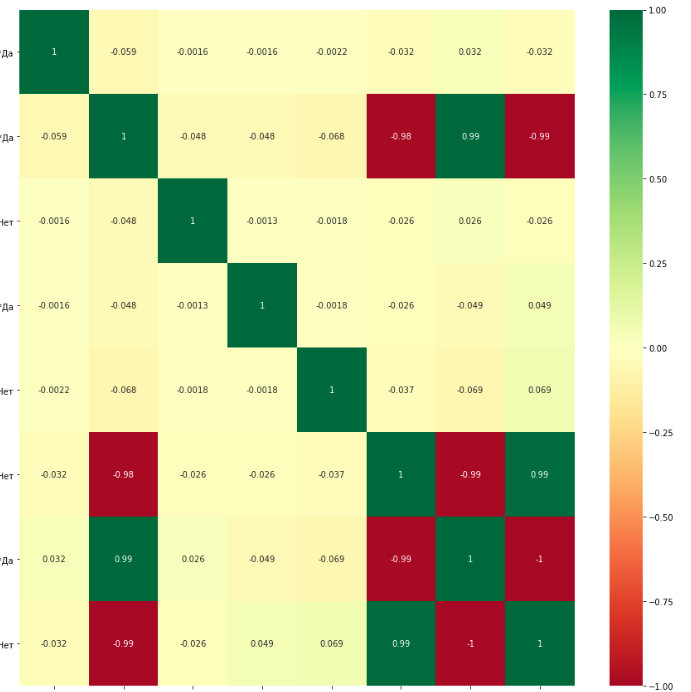

In [57]:
Image("6.png")

In [58]:
data_3['Sv_4'].unique()

array(['310*Клап*Рук*Нет', '310*Клап*Рук*Да', '310*Рук*Нет', '310*Рук*Да',
       'Клап*Рук*Нет', 'Клап*Рук*Да'], dtype=object)

In [59]:
data_Y = data_2.loc[data_2['Sv_4'] == '310*Клап*Рук*Да']
data_N = data_2.loc[data_2['Sv_4'] == '310*Клап*Рук*Нет']
data_3 = pd.concat([data_Y,data_N])

In [60]:
data_310 = pd.get_dummies(data_3[['Sv_2', 'Sv_4']])
corrmat = data_310.corr(method='pearson')
top_corr_features = corrmat.index
plt.figure(figsize=(15,15))
# Конфиденциальная информация
# g=sns.heatmap(data_310[top_corr_features].corr(),annot=True,cmap="RdYlGn")

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

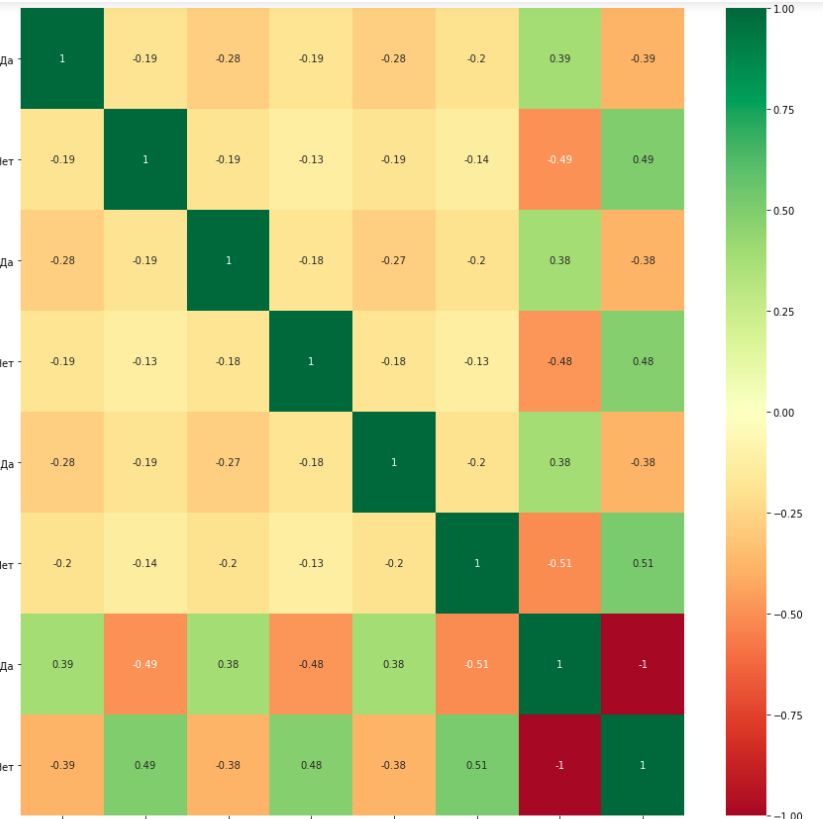

In [61]:
Image("7.png")

# Набор с 320

## Отберем данные из 320 набора

In [62]:
# Сначала отберем заказы с набором из 310 корпуса
data_3_1 = data_2.loc[data_2['Sv_3'] == '320*Клап*Рук']
data_3_2 = data_2.loc[data_2['Sv_3'] == '320*Рук']
data_3_3 = data_2.loc[data_2['Sv_3'] == '320*Клап']
data_3_4= data_2.loc[data_2['Sv_3'] == 'Клап*Рук']
data_3 = pd.concat([data_3_1, data_3_2, data_3_3, data_3_4])

In [63]:
data_320 = pd.get_dummies(data_3['Sv_1'])

In [64]:
corrmat = data_320.corr(method='pearson')
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
# Конфиденциальная информация
# g=sns.heatmap(data_320[top_corr_features].corr(),annot=True,cmap="RdYlGn")

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

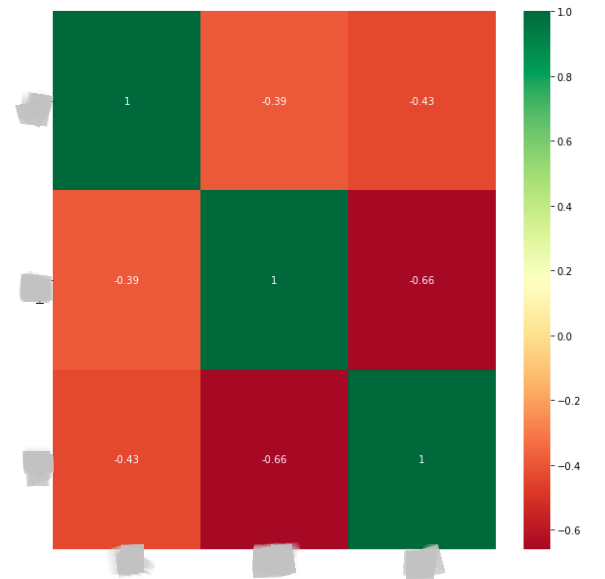

In [65]:
Image("8.png")

In [66]:
data_320 = pd.get_dummies(data_3['Sv_2'])

In [67]:
corrmat = data_320.corr(method='pearson')
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
# Конфиденциальная информация
# g=sns.heatmap(data_320[top_corr_features].corr(),annot=True,cmap="RdYlGn")

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

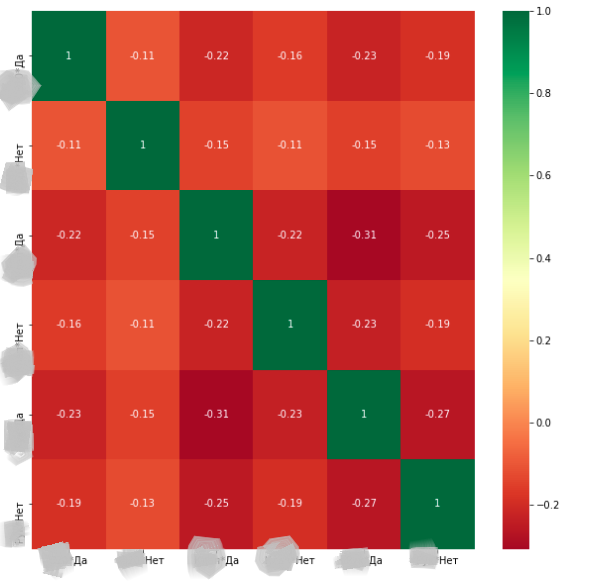

In [68]:
Image("9.png")

In [69]:
data_4 = data_2.loc[data_2['ЗаказКлиентаПартнерБизнесРегион'] == 'Новосибирская обл']

In [70]:
data_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7798 entries, 3 to 20967
Data columns (total 21 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   ЗаказКлиентаСсылка                       7798 non-null   object        
 1   ЗаказКлиентаДата                         7798 non-null   datetime64[ns]
 2   ЗаказКлиентаПартнерКод                   7798 non-null   object        
 3   ЗаказКлиентаПартнер                      7798 non-null   object        
 4   ЗаказКлиентаПартнерБизнесРегион          7798 non-null   object        
 5   ЗаказКлиентаПартнерОсновнойМенеджер      7798 non-null   object        
 6   ЗаказКлиентаСуммаДокумента               7798 non-null   float64       
 7   ЗаказКлиентаСтатус                       7798 non-null   object        
 8   ЗаказКлиентаНоменклатураКод              7798 non-null   object        
 9   ЗаказКлиентаНоменклатура                

In [71]:
data_Y = data_4.loc[data_4['Sv_4'] == '320*Клап*Рук*Да']
data_N = data_4.loc[data_4['Sv_4'] == '320*Клап*Рук*Нет']
data_3 = pd.concat([data_Y,data_N])

In [72]:
data_310 = pd.get_dummies(data_3[['Sv_2', 'Sv_4']])
corrmat = data_310.corr(method='pearson')
top_corr_features = corrmat.index
plt.figure(figsize=(15,15))
# Конфиденциальная информация
# g=sns.heatmap(data_310[top_corr_features].corr(),annot=True,cmap="RdYlGn")

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

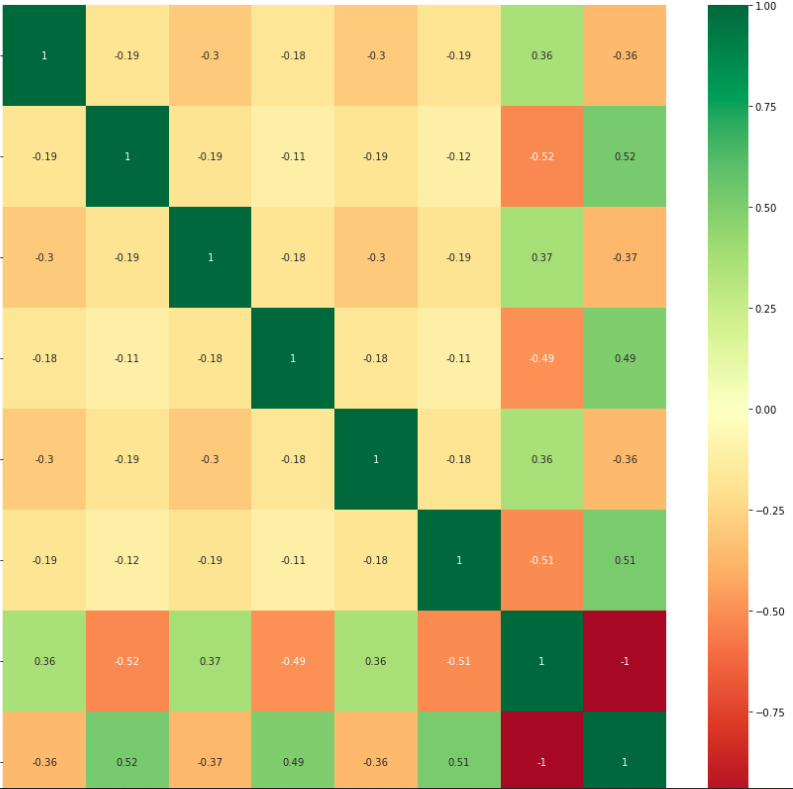

In [73]:
Image("10.png")